# PyVRP

in this lab, we use the `vrplib` format which provided by PyVRP: https://github.com/PyVRP/Instances.git

In [9]:
from pyvrp import read

INSTANCE = read("data/X-n439-k37.vrp", round_func="round")

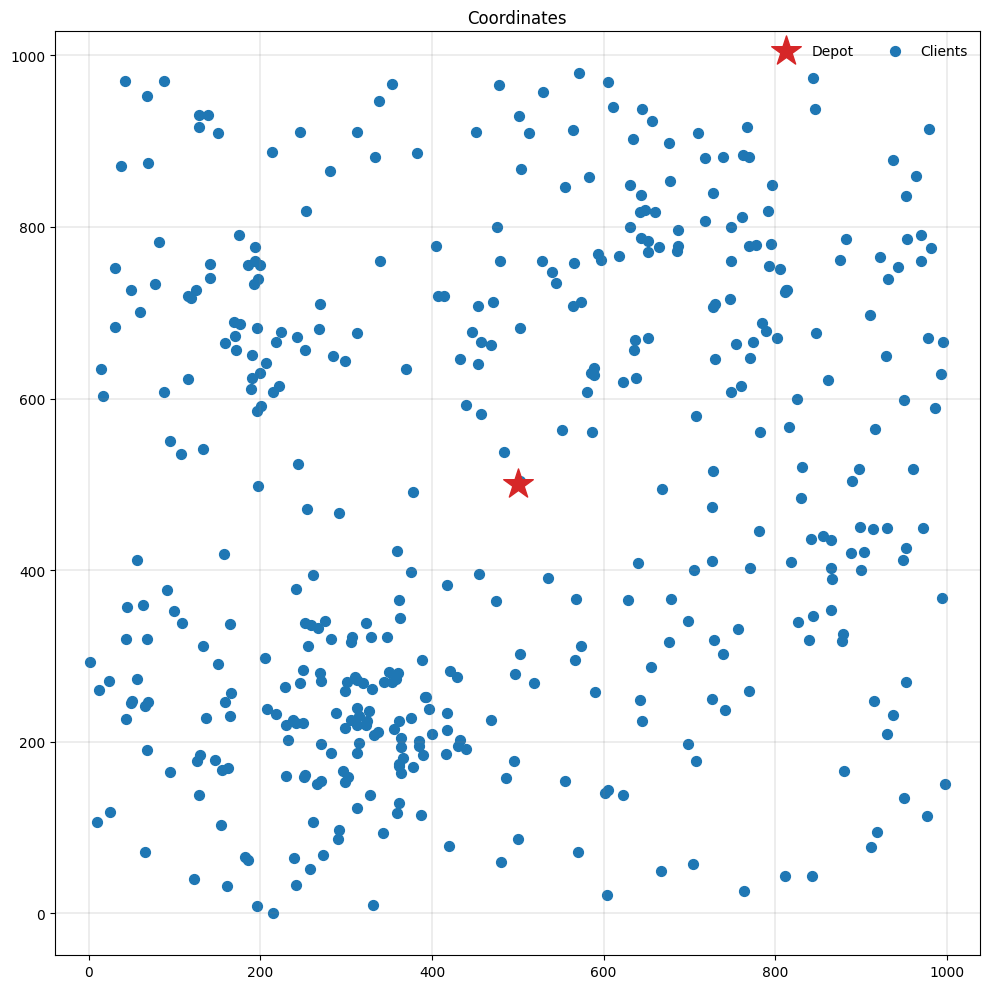

In [13]:
import matplotlib.pyplot as plt
from pyvrp.plotting import plot_coordinates

_, ax = plt.subplots(figsize=(10, 10))
plot_coordinates(INSTANCE, ax=ax)
plt.tight_layout()

In [14]:
from pyvrp import Model
from pyvrp.stop import MaxIterations, MaxRuntime

model = Model.from_data(INSTANCE)
result = model.solve(stop=MaxIterations(2000), seed=42)
print(result)

Solution results
    # routes: 37
   # clients: 438
   objective: 36727.00
# iterations: 2000
    run-time: 40.38 seconds

Routes
------
Route #1: 414 217 236 105 2 169 3 348 260 26 326 
Route #2: 72 97 400 299 392 57 139 200 145 122 418 206 
Route #3: 172 155 92 275 41 406 270 308 202 149 
Route #4: 335 42 239 281 218 375 296 43 347 211 250 312 
Route #5: 71 228 346 162 435 166 345 385 438 381 404 195 
Route #6: 44 324 229 268 380 227 249 325 237 121 353 422 
Route #7: 433 372 264 352 315 86 225 409 110 245 280 393 
Route #8: 421 416 407 366 384 403 17 412 83 388 303 241 
Route #9: 233 420 396 423 391 337 242 360 342 221 377 115 
Route #10: 413 432 351 266 329 319 338 271 289 257 138 246 
Route #11: 253 309 252 101 402 428 89 293 339 66 126 297 
Route #12: 437 323 243 321 383 376 350 286 341 98 137 283 
Route #13: 251 65 159 15 154 91 118 153 215 193 285 47 
Route #14: 146 334 144 431 197 7 344 80 130 61 189 25 
Route #15: 173 88 210 22 56 75 196 274 116 113 90 140 
Route #16: 333 31 

In [15]:
from vrplib import read_solution
BKS = read_solution("data/X-n439-k37.sol")
gap = 100 * (result.cost() - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {result.cost()}.")
print(f"This is {gap:.1f}% worse than the best known", end=" ")
print(f"solution, which is {BKS['cost']}.")

Found a solution with cost: 36727.
This is 0.9% worse than the best known solution, which is 36391.


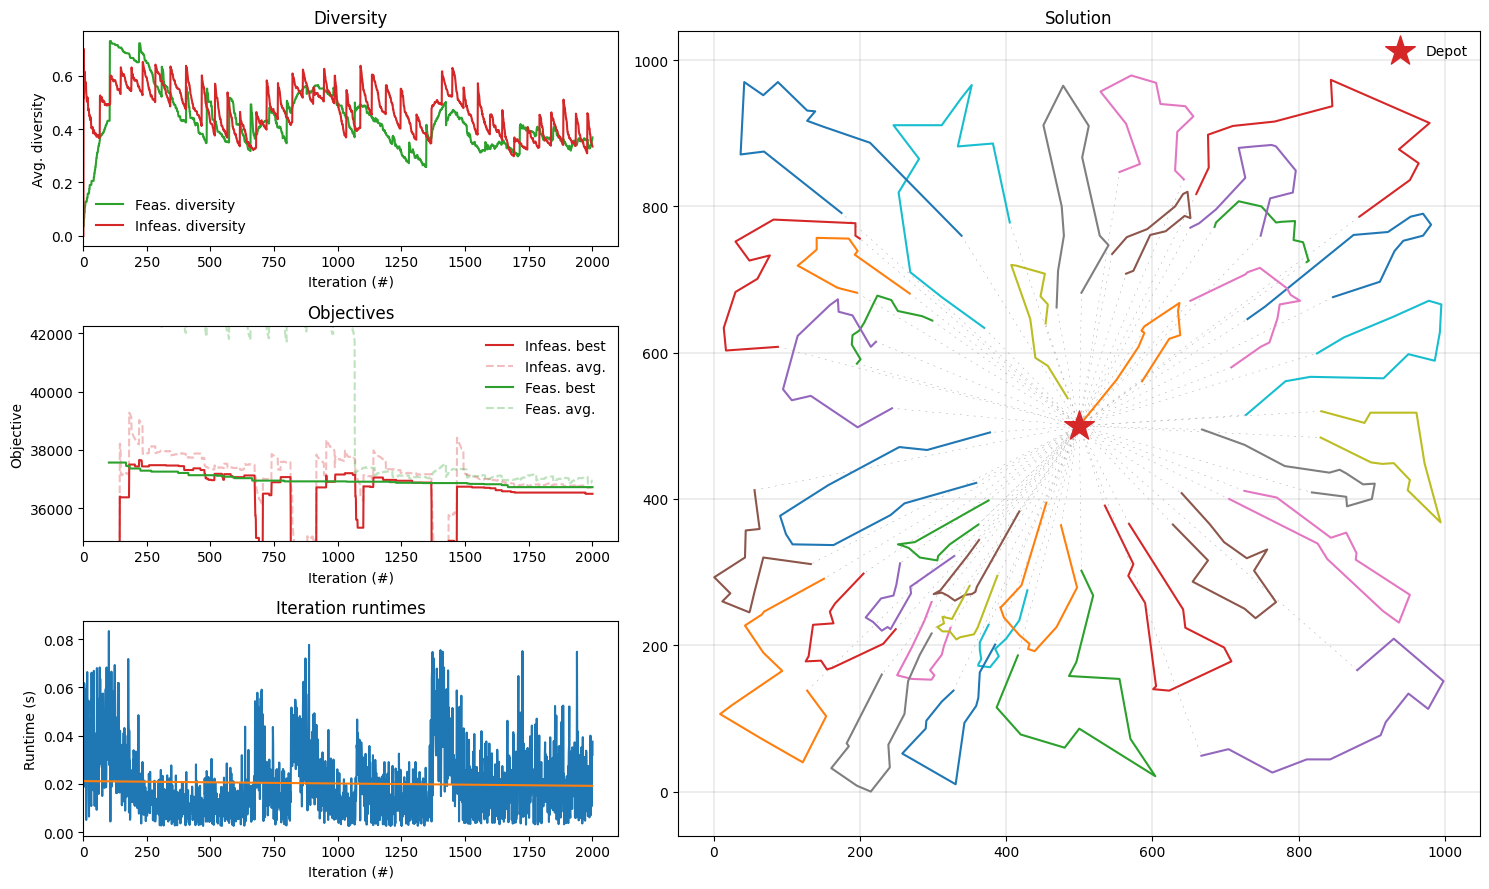

In [16]:
from pyvrp.plotting import plot_result
fig = plt.figure(figsize=(15, 9))
plot_result(result, INSTANCE, fig)
fig.tight_layout()

# RoutingBlocks

In [12]:
import random
import sys
from itertools import product
from pathlib import Path
from typing import List

import routingblocks
import routingblocks_cvrp as cvrp
import vrplib

In [13]:
def read_instance(instance_name: str, basedir: Path = Path('instances/')):
    instance_file = basedir / instance_name
    if not instance_file.exists():
        basedir.mkdir(parents=True, exist_ok=True)
        # Download the CVRP problem instance if it does not exist
        vrplib.download_instance(instance_name, str(instance_file))

    # Load the CVRP problem instance
    return vrplib.read_instance(instance_file)

In [14]:
def create_cvrp_instance(instance):
    # Create CVRP vertices
    n = len(instance['demand'])
    vertices = [
        cvrp.create_cvrp_vertex(i, str(i), False, i == instance['depot'][0], cvrp.CVRPVertexData(instance['demand'][i]))
        for i in range(n)]
    # Create CVRP arcs
    arcs = [
        [cvrp.create_cvrp_arc(cvrp.CVRPArcData(instance['edge_weight'][i][j])) for j in range(n)] for i in range(n)
    ]

    return routingblocks.Instance(vertices, arcs, len(vertices))


In [17]:
def optimize_solution(evaluation: routingblocks.Evaluation, instance: routingblocks.Instance,
                      solution: routingblocks.Solution):
    # Create a local search solver
    solver = routingblocks.LocalSearch(instance, evaluation, evaluation, routingblocks.BestImprovementPivotingRule())
    # Create some operators
    # Create the arc set - by default all arcs are included
    full_arc_set = routingblocks.ArcSet(len(instance))
    operators = [
        routingblocks.operators.SwapOperator_0_1(instance, full_arc_set),
        routingblocks.operators.SwapOperator_1_1(instance, full_arc_set),
        routingblocks.operators.InterRouteTwoOptOperator(instance, full_arc_set)
    ]
    # Optimize the solution (inplace)
    solver.optimize(solution, operators)
    return solution

In [18]:
def distribute_randomly(sequence, num_subsequences: int, randgen=random.Random()) -> List[List]:
    subsequences = [[] for _ in range(num_subsequences)]
    for item in sequence:
        subsequences[randgen.randint(0, len(subsequences) - 1)].append(item)
    return subsequences


def generate_random_solution(evaluation: routingblocks.Evaluation, instance: routingblocks.Instance,
                             random: routingblocks.Random):
    customers = [x.vertex_id for x in instance.customers]
    sol = routingblocks.Solution(evaluation, instance,
                                 [routingblocks.create_route(evaluation, instance, r) for r in
                                  distribute_randomly(customers, instance.fleet_size,
                                                      random)])
    return sol

In [15]:
basedir = Path("./data")
instance = read_instance(instance_name="X-n439-k37.vrp", basedir=basedir)

In [19]:
cpp_instance = create_cvrp_instance(instance)
evaluation = cvrp.CVRPEvaluation(instance['capacity'])

max_demand = instance['demand'].max()
max_dist = instance['edge_weight'].max()

In [20]:
evaluation.overload_penalty_factor = max_dist / max_demand

# Create a simple solution by applying local search to a random solution
randgen = routingblocks.Random()
random_solution = generate_random_solution(evaluation, cpp_instance, randgen)
optimized_solution = optimize_solution(evaluation, cpp_instance, random_solution)
print(optimized_solution)
print("Cost:", optimized_solution.cost, optimized_solution.cost_components)

Solution(cost=38916, routes=[[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,399,417,368,290,356,190,125,222,310,178,313,265,0,]
[0,172,149,422,353,325,249,380,321,243,383,323,283,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,124,99,77,364,259,30,291,174,382,84,4,132,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,284,320,234,405,168,272,214,198,52,95,269,96,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,277,45,212,94,54,27,141,100,51,164,199,53,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,85,167,49,46,40,127,76,201,203,247,186,128,0,]
[0,0,]
[0,59,136,187,362,434,2,169,3,411,348,92,155,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,81,179,170,183,205,150,282,219,142,163,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]
[0,0,]

In [23]:
from vrplib import read_solution
BKS = read_solution("data/X-n439-k37.sol")
gap = 100 * (optimized_solution.cost - BKS["cost"]) / BKS["cost"]
print(f"Found a solution with cost: {optimized_solution.cost}.")
print(f"This is {gap:.1f}% worse than the best known", end=" ")
print(f"solution, which is {BKS['cost']}.")

Found a solution with cost: 38916.01171875.
This is 6.9% worse than the best known solution, which is 36391.
